In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pickle
import cv2
import os
import tensorflow
from os import listdir, rmdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!git clone https://github.com/spMohanty/PlantVillage-Dataset.git

Mounted at /content/drive


In [ ]:
#os.environ['KAGGLE_USERNAME'] = "revanthpavuluri" # username from the json file
#os.environ['KAGGLE_KEY'] = "434c2126d8a1c8b9a12cd22cb30e1619" # key from the json file

#!kaggle kernels output emmarex/plant-disease-detection-using-keras -p /content/drive/MyDrive/PlantDiseaseData/Models/

In [ ]:
#%mv /content/data/ /content/drive/MyDrive/PlantData

In [ ]:
#%mv /content/drive/MyDrive/PlantData/ /content/drive/MyDrive/PlantDiseaseData/Data/

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/PlantDiseaseData/Data/'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
LIS = listdir(directory_root+"PlantData")
for i in LIS:
  path = directory_root+"PlantData/"+i
  if len(listdir(path)) == 0:
    rmdir(path)


In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Image loading completed


In [ ]:
image_size = len(image_list)

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('/content/drive/MyDrive/PlantDiseaseData/Models/label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
80/80 [==============================] - 48s 469ms/step - loss: 0.6534 - accuracy: 0.2809 - val_loss: 0.7860 - val_accuracy: 0.0641
Epoch 2/25
80/80 [==============================] - 34s 429ms/step - loss: 0.2782 - accuracy: 0.3797 - val_loss: 0.3853 - val_accuracy: 0.1156
Epoch 3/25
80/80 [==============================] - 34s 430ms/step - loss: 0.1440 - accuracy: 0.6297 - val_loss: 0.4805 - val_accuracy: 0.0953
Epoch 4/25
80/80 [==============================] - 35s 430ms/step - loss: 0.1083 - accuracy: 0.7184 - val_loss: 0.4886 - val_accuracy: 0.0719
Epoch 5/25
80/80 [==============================] - 34s 430ms/step - loss: 0.0889 - accuracy: 0.7641 - val_loss: 0.3973 - val_accuracy: 0.0969
Epoch 6/25
80/80 [==============================] - 35s 432ms/step - loss: 0.0827 - accuracy: 0.7879 - val_loss: 0.2531 - val_accuracy: 0.2328
Epoch 7/25
80/80 [==============================] - 34s 427ms/step - loss: 0.0766 - accuracy: 0.7930 - val_loss: 0.1586 - val_accuracy: 0.5094

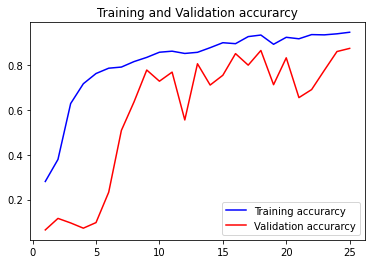

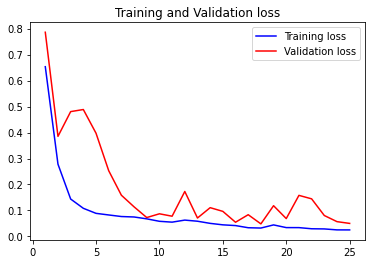

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
20/20 [==============================] - 1s 33ms/step - loss: 0.0502 - accuracy: 0.8766
Test Accuracy: 87.65624761581421


In [ ]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model_out.pkl', 'wb'))

In [ ]:
%mv /content/cnn_model_out.pkl /content/drive/MyDrive/PlantDiseaseData/Models/

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/PlantDiseaseData/Models/cnn_model.pkl', 'rb'))

In [ ]:
from keras.models import Sequential

In [ ]:
import keras.utils as image
import requests

labels = ["Blueberry___healthy","Apple___Cedar_apple_rust","Apple___Apple_scab",
"Cherry_(including_sour)___Powdery_mildew",
"Apple___Black_rot","Apple___healthy","Cherry_(including_sour)___healthy","Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
"Corn_(maize)___Common_rust_",
"Corn_(maize)___Northern_Leaf_Blight",
"Corn_(maize)___healthy",
"Grape___Black_rot",
"Grape___Esca_(Black_Measles)",
"Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
"Grape___healthy",
"Orange___Haunglongbing_(Citrus_greening)"]
def modpred(path):
  img = image.load_img("/content/"+path, target_size=(256, 256))

    # Preprocessing the image
  x = image.img_to_array(img)
    # x = np.true_divide(x, 255)
  x = np.expand_dims(x, axis=0)

    # Be careful how your trained model deals with the input
    # otherwise, it won't make correct prediction!
  x = preprocess_input(x, mode='caffe')

  preds = model.predict(x)
  print(preds)
  lab = np.where(preds[0]==1)[0][0]
  return labels[::-1][lab]

In [ ]:
path = "00b1f292-23dd-44d4-aad3-c1ffb6a6ad5a___RS_LB 4479.JPG" #@param {type:"string"}
if "//" in path:
  response = requests.get(path)
  path = path.split("/")[-1]
  img = open(path, "wb").write(response.content)
modpred(path)



1/1 [==============================] - 7s 7s/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


'Apple___healthy'

# New Section